In [1]:
%matplotlib inline
import os
import random
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td 
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import math
import xml.etree.ElementTree as ET
import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'
# dataset_root_dir = 'VOCdevkit/VOC2012/'

In [23]:
class VOCDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(448, 448), S=7): 
        super(VOCDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.S = S
        if mode == 'train':
            self.list_file = os.path.join(root_dir, 'ImageSets/Main/trainval.txt')
        else:
            self.list_file = os.path.join(root_dir, 'ImageSets/Main/val.txt')
        
        self.annot_dir = os.path.join(root_dir, 'Annotations')
        
        with open(self.list_file) as f:
            lines = f.readlines()    
        
        self.image_names = []
        for line in lines:
            self.image_names.append(line[:11])
        
        self.images_dir = os.path.join(root_dir, 'JPEGImages')

    def __len__(self):
        return len(self.image_names)

    def __repr__(self):
        return "VOCDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)

    def __getitem__(self, idx):
        iname = self.image_names[idx]
        img_path = os.path.join(self.images_dir, iname+'.jpg') 
        
        # Read annotations from xml
        tree = ET.parse(os.path.join(self.annot_dir, iname+'.xml'))
        boxes = []
        labels = []
        for obj in tree.iter(tag='object'):
            bbox = [int(obj.find('bndbox').find('xmax').text),\
                    int(obj.find('bndbox').find('ymax').text),\
                    int(obj.find('bndbox').find('xmin').text),\
                    int(obj.find('bndbox').find('ymin').text)]
            label = obj.find('name').text
            boxes.append(bbox)
            labels.append(label)
        isize = (int(tree.find('size').find('width').text), int(tree.find('size').find('height').text))
        boxes = torch.FloatTensor(boxes)
        
        # Read images and perform random processing and normalization
        img = cv2.imread(img_path)
        if self.mode == 'train':
            img = self.RandomBrightness(img)
            img = self.RandomSaturation(img)
        img = cv2.resize(img, self.image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        transform = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5, .5,.5),(.5, .5, .5))
            ])
        img = transform(img)
        
        target = self.encoder(boxes, labels, isize)
        
        # Return img(3x448x448 torch tensor), target(7x7x30 torch tensor)
        return img, target
    
    def encoder(self, boxes, labels, isize):
        '''
        Encode boxes and labels to 7x7x30 tensor. For each area, the 30 len tensor has such structure:
        [ 20(class label) | 1(C) | 1(C) | 4(width, height, center_w, center_h, and all are ratio) | 4(the same) ]
        '''
        S = self.S
        class_dict = {'aeroplane':0, 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4, 'bus':5, 'car':6, 'cat':7, \
                     'chair':8, 'cow':9, 'diningtable':10, 'dog':11, 'horse':12, 'motorbike':13, 'person':14, \
                      'pottedplant':15, 'sheep':16, 'sofa':17, 'train':18, 'tvmonitor':19}
        target = torch.zeros((S, S, 30))
        wh = boxes[:, :2]-boxes[:, 2:]
        cxcy = (boxes[:, :2]+boxes[:, 2:])/2
        for i in range(cxcy.size()[0]):
            center = cxcy[i]
            loc = (int(center[0]/(isize[0]/S)), int(center[1]/(isize[1]/S)))
            target[loc[0], loc[1], 20] = 1
            target[loc[0], loc[1], 21] = 1
            target[loc[0], loc[1], class_dict[labels[i]]] = 1
            normalized_wh = torch.tensor([wh[i,0]/isize[0], wh[i,1]/isize[1]])
            normalized_center = torch.tensor([center[0]/isize[0], center[1]/isize[1]])
            target[loc[0], loc[1], 22:24] = normalized_wh
            target[loc[0], loc[1], 24:26] = normalized_center
            target[loc[0], loc[1], 26:28] = normalized_wh
            target[loc[0], loc[1], 28:30] = normalized_center
            
        return target
    
    def RandomBrightness(self, bgr):
        if np.random.random() < 0.5:
            hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            adjust = np.random.choice([0.5, 1.5])
            v = v*adjust
            v = np.clip(v, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h, s, v))
            bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        return bgr

    def RandomSaturation(self, bgr):
        if np.random.random() < 0.5:
            hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            adjust = np.random.choice([0.5, 1.5])
            s = s*adjust
            s = np.clip(s, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h, s, v))
            bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        return bgr

    

In [24]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    ax.axis('off') 
    return h

torch.Size([7, 7, 30])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


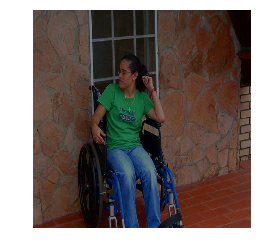

In [25]:
train_set = VOCDataset(dataset_root_dir)
img, target = train_set[random.randint(0, len(train_set))]
myimshow(img)
print(target.shape)
print(target[3][3])

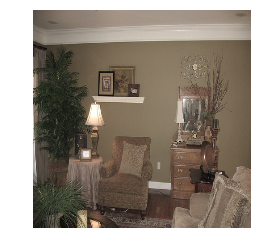

In [26]:
val_set = VOCDataset(dataset_root_dir, mode='val')
img, target = train_set[random.randint(0, len(train_set))]
myimshow(img)

In [27]:
class ImageOutput:
    def __init__(self, y, S, B, C):
        self.cells = list()
        for i in range(S):
            for j in range(S):
                t = y[i][j]
                label_for_this_cell = dict()
                #  t is a vector with length 30
                label_for_this_cell['C'] = t[:C]
                label_for_this_cell['boxes'] = list()
                label_for_this_cell['boxes'].append(dict())
                label_for_this_cell['boxes'].append(dict())
                label_for_this_cell['boxes'][0]['p_obj'] = t[20]
                label_for_this_cell['boxes'][1]['p_obj'] = t[21]
                label_for_this_cell['boxes'][0]['w'] = t[22]
                label_for_this_cell['boxes'][0]['h'] = t[23]
                label_for_this_cell['boxes'][0]['x'] = t[24]
                label_for_this_cell['boxes'][0]['y'] = t[25]
                label_for_this_cell['boxes'][1]['w'] = t[26]
                label_for_this_cell['boxes'][1]['h'] = t[27]
                label_for_this_cell['boxes'][1]['x'] = t[28]
                label_for_this_cell['boxes'][1]['y'] = t[29]
                self.cells.append(label_for_this_cell)


In [28]:
def compute_iou(rec1, rec2):
    
    """
    computing IoU
    :param rec1: (y0, x0, y1, x1), which reflects
            (top, left, bottom, right)
    :param rec2: (y0, x0, y1, x1)
    :return: scala value of IoU
    """
    # computing area of each rectangles
    S_rec1 = (rec1[2] - rec1[0]) * (rec1[3] - rec1[1])
    S_rec2 = (rec2[2] - rec2[0]) * (rec2[3] - rec2[1])
 
    # computing the sum_area
    sum_area = S_rec1 + S_rec2
 
    # find the each edge of intersect rectangle
    left_line = max(rec1[1], rec2[1])
    right_line = min(rec1[3], rec2[3])
    top_line = max(rec1[0], rec2[0])
    bottom_line = min(rec1[2], rec2[2])
 
    # judge if there is an intersect
    if left_line >= right_line or top_line >= bottom_line:
        return 0
    else:
        intersect = (right_line - left_line) * (bottom_line - top_line)
        return intersect / (sum_area - intersect)
    

In [29]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
    
    def criterion(self, y, d):
        # y is the network output for a mini-batch, and dd is the corresponding labels.
        batch_size = len(y)
    
        sum_loss = 0
    
        for i in range(batch_size):
            yy = y[i]
            dd = d[i]
            # yy: 7 x 7 x 30
            # dd: 7 x 7 x 25, since dd has only one sub-box for one cell
            sum_loss += self.get_loss_for_one_image(self, yy, dd)
        return sum_loss / (1.0 * batch_size)
    
    def get_loss_for_one_image(self, y, d):
        # y is the network output for one image, and d is the corresponding label.
        loss = 0
        S = 7  # S x S cells in one image
        B = 2  # B sub-boxex in one cell
        C = 20  # C classes to classify
        yy = ImageOutput(y, S, B, C)
        dd = ImageOutput(d, S, 1, C)
    
        for i in range(S*S):
            loss += self.get_loss_for_one_cell(yy.cells[i], dd.cells[i])
    
        return loss
    
    def get_loss_for_one_cell(self, y_cell, d_cell):
        # Here is a detailed explanation for loss:
        # https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088
    
        lambda_coord = 5
        lambda_noobj = 0.5
        classification_loss = 0
        localization_loss = 0
        confidence_loss = 0
    
        has_object_in_this_cell = False
        if d_cell['boxes'][0]['p_obj'] == 1:
            has_object_in_this_cell = True
    
        responsible_box = self.get_responsible_box(y_cell['boxes'], d_cell['boxes'])
    
        # localization loss
        if has_object_in_this_cell:
            x_diff = responsible_box['x'] - d_cell['boxes'][0]['x']
            y_diff = responsible_box['y'] - d_cell['boxes'][0]['y']
            localization_loss += lambda_coord * (x_diff ** 2 + y_diff ** 2)
    
            sqrt_w_diff = math.sqrt(responsible_box['w']) -  math.sqrt(d_cell['boxes'][0]['w'])
            sqrt_h_diff =  math.sqrt(responsible_box['h']) -  math.sqrt(d_cell['boxes'][0]['h'])
            localization_loss += lambda_coord * (sqrt_w_diff ** 2 + sqrt_h_diff ** 2)
    
        # confidence loss
        if has_object_in_this_cell:
            tuple_responsible = (responsible_box['x'], responsible_box['y'], responsible_box['w'], responsible_box['h'])
            tuple_groundtruth = (d_cell['boxes'][0]['x'], d_cell['boxes'][0]['y'],
                                 d_cell['boxes'][0]['w'], d_cell['boxes'][0]['h'])
            iou = compute_iou(tuple_responsible, tuple_groundtruth)
            C_diff = responsible_box['p_obj'] * iou - d_cell['boxes'][0]['p_obj']
            # confidence = p_obj * iou
            # for ground-truth, the confidence is equal to its p_obj
            confidence_loss += C_diff ** 2
        else:
            # Question here!!! for boxes that don't contain objects, do we need to compute confidence as P_obj * IOU?
            # If so, the confidence for those boxes is always zero, which doesn't make sense for optimization
    
            # Here, we sum up the confidence loss of all boxes.
            for box in y_cell['boxes']:
                # C_diff = box['p_obj'] - d_cell['boxes'][0]['p_obj'], with d_cell['boxes'][0]['p_obj'] = 0
                C_diff = box['p_obj']
                confidence_loss += lambda_noobj * (C_diff ** 2)
    
        # classification loss
        if has_object_in_this_cell:
            C = len(y_cell['C'])
            for i in range(C):
                pc_diff = y_cell['C'][i] - d_cell['C'][i]
                classification_loss += (pc_diff ** 2)
    
        return localization_loss + confidence_loss + classification_loss
    
    def get_responsible_box(self, y_boxes, d_boxes):
        max_iou = -1
        max_iou_box = None
        d_box = (d_boxes[0]['x'], d_boxes[0]['y'], d_boxes[0]['w'], d_boxes[0]['h'])
        for box in y_boxes:
            this_box = (box['x'], box['y'], box['w'], box['h'])
            iou = compute_iou(this_box, d_box)
            if iou > max_iou:
                max_iou = iou
                max_iou_box = box
        return max_iou_box
    

In [30]:
class YOLO(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(YOLO, self).__init__()
        C = 20  
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=7*7*1024, out_features=4096),
            nn.Dropout(p = 0.5),
            nn.LeakyReLU(0.1)
        )
        self.fc2 = nn.Sequential(nn.Linear(in_features=4096, out_features=7 * 7 * (2 * 5 + C)))
        
    def forward(self, x):
        f = self.features(x)
        
        y = self.conv1(f)
        y = self.conv2(y)
        y = y.view(y.size(0), -1)
        y = self.fc1(y)
        y = self.fc2(y)
        return y

In [31]:
class ClassificationStatsManager(nt.StatsManager):

    def __init__(self):
        super(ClassificationStatsManager, self).__init__()

    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0

    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * (1 - loss) # COMPLETE
        return {'loss': loss, 'accuracy': accuracy}
    

In [33]:
lr = 1e-3
net = YOLO(num_classes=20)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
# TODO: set learning rate decay
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="YOLO", perform_validation_during_training=True)


Start/Continue training from epoch 0


TypeError: get_loss_for_one_image() takes 3 positional arguments but 4 were given

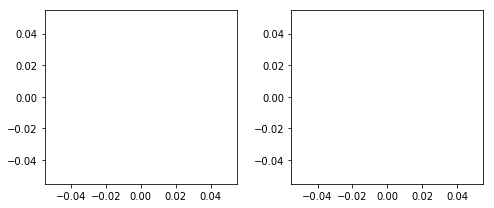

In [34]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)], label='training accuracy')
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label='evaluation loss')
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)], label='evaluation accuracy')
    plt.tight_layout()
    fig.canvas.draw()
    
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))
